# Analyzing Global Health and Environmental Trends Using World Bank Data: <br>A Data-Driven Study with MySQL Database Integration and Python Analysis

---
**We greatly acknowledge the World Bank Group for the collection and sharing of the data. To access the World Bank Open Data library, visit: [World Bank Open Data](https://data.worldbank.org/)**

---

In [ ]:
# Check that jupyter lab points to your project's environment directory
import sys
sys.executable

# 1. The Datasets

The indicator descriptions below are based on the metadata provided with each dataset. For ‘Total Greenhouse Gas Emissions Including LULUCF (Mt CO2e),’ no metadata was available, so we conducted a brief research to understand it.

## 1.1. Health Indicators

### 1.1.1. Current Health Expenditure (% of GDP)
This indicator shows how much a country spends on health care compared to its total economic output (GDP). It includes the health services and goods that are used within the year. It does not cover long-term investments such as buildings, medical equipment, IT systems, or vaccine stockpiles for emergencies.

### 1.1.2. People Using at Least Basic Drinking Water Services, Rural (% of Rural Population) 
This indicator shows the share of rural residents who have access to at least basic drinking water services. It includes both basic and safely managed water services. Basic services refer to drinking water from an improved source, as long as the total round-trip collection time is under 30 minutes. Improved sources include piped water, boreholes, protected wells or springs, and packaged or delivered water.

### 1.1.3. People Using at Least Basic Drinking Water Services, Urban (% of Urban Population)
This indicator shows the share of urban residents who have access to at least basic drinking water services. It includes both basic and safely managed water services. Basic services mean getting water from an improved source, as long as the total time to go there and return is under 30 minutes. Improved sources include piped water, boreholes, protected wells or springs, and packaged or delivered water.

### 1.1.4. People Using Safely Managed Sanitation Services, Rural (% of Rural Population)
This indicator shows the share of rural residents who use improved sanitation facilities that are not shared with other households. It includes systems where waste is safely managed on-site or collected and treated offsite. Improved sanitation facilities include flush or pour-flush toilets connected to sewers, septic tanks or pit latrines, as well as ventilated improved pit latrines, composting toilets, and pit latrines with a slab.

### 1.1.5. People Using Safely Managed Sanitation Services, Urban (% of Urban Population)
This indicator shows the share of urban residents who use improved sanitation facilities that are not shared with other households. It includes systems where waste is safely managed on-site or collected and treated offsite. Improved sanitation facilities include flush or pour-flush toilets connected to sewers, septic tanks or pit latrines, as well as ventilated improved pit latrines, composting toilets, and pit latrines with a slab.

## 1.2. Environment Indicators

### 1.2.1. Total Greenhouse Gas Emissions Including LULUCF (Mt CO2e)
This indicator measures the total greenhouse gas emissions of a country, including the effects of land use, land-use changes, and forestry (LULUCF), expressed in million tonnes of CO₂ equivalent. LULUCF accounts for carbon released or absorbed due to changes in land cover, such as deforestation, afforestation, or forest management. This gives a complete view of a country’s contribution to climate change.

### 1.2.2. Population, Total
This indicator reports the total number of people living in a country, based on the de facto population concept. It counts all residents, no matter their legal status or citizenship. The figures represent estimates taken around the middle of each year.

### 1.2.3. Renewable Energy Consumption (% of Total Final Energy Consumption)
This indicator shows the percentage of a country’s total final energy use that comes from renewable sources. It reflects how much of the energy consumed is produced from renewables instead of fossil fuels.

# 2. Import Libraries

In [2]:
import numpy as np  # Numerical computing library
import pandas as pd  # Data handling
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # An updated matplotlib (for better visualizations)
import pymysql  # MySQL database connector for Python
import chardet  # Library for automatic character encoding detection
import re  # Regular expressions for string manipulation and pattern matching

import custom_functions  # Custom functions for this project (e.g., CSV cleaning, encoding detection)

pd.options.display.max_columns = 100  # Display all columns
# Show full column content
pd.set_option('display.max_colwidth', None)

# 3. Data Harvesting

## 3.1. Read Datasets to DataFrames

A detailed exploration of the CSV files is necessary to ensure they can be read correctly into DataFrames.

We selected five health indicators and three environmental indicators. Some of these files are too complex to be read directly into DataFrames. The complexity became apparent when we realized that pandas.read_csv() could not handle the files properly, producing unreliable results.

Rather than choosing easier files, we took this as an opportunity to develop a step-by-step solution and learn as much as possible from the process. The Pythonic approach we followed includes the steps below:

1. Ensure the correct file encoding.
2. Fetch the CSV files into Python’s runtime (without using pandas, since it could not read the files correctly).
3. Explore the fetched CSV content to identify the issues.
4. Write scripts to address one problem at a time, progressing toward the final solution.

The indicators that required this special treatment were **"Population, total"** and **"Renewable energy consumption (% of total final energy consumption)"**. For this reason, we separated these two files from the rest, assigning them the notation 2, while the remaining files use the notation 1.

To handle the process described above, we also created three custom functions for reading and cleaning the CSV files. We also included docstrings in our functions to improve their readability and understanding.

Therefore, as the first preprocessing step, we create the lists with file paths and data abbreviations. The mechanics are simple: the first element of filepaths_1 corresponds to the first element of abbreviations_1. The same applies to filepaths_2 and abbreviations_2. So, the custom creation order of the list elements matters. These lists make automation easier and help map each file to its abbreviation.

In [3]:
# File paths for notation 1 ('che', 'wr', 'wu', 'sr', 'su', 'gem')
filepaths_1 = ['original_data_and_region_mapping/Current health expenditure (% of GDP).csv',
               'original_data_and_region_mapping/People using at least basic drinking water services, rural (% of rural population).csv',
               'original_data_and_region_mapping/People using at least basic drinking water services, urban (% of urban population).csv',
               'original_data_and_region_mapping/People using safely managed sanitation services, rural (% of rural population).csv',
               'original_data_and_region_mapping/People using safely managed sanitation services, urban (% of urban population).csv',
               'original_data_and_region_mapping/Total greenhouse gas emissions including LULUCF (Mt CO2e).csv']

# File paths for notation 2 ('pop', 'ren')
filepaths_2 = ['original_data_and_region_mapping/Population, total.csv',
               'original_data_and_region_mapping/Renewable energy consumption (% of total final energy consumption).csv']

# Abbreviations for easy mapping: notation 1
abbreviations_1 = ['che', 'wr', 'wu', 'sr', 'su', 'gem']

# Abbreviations for easy mapping: notation 2
abbreviations_2 = ['pop', 'ren']

**Step 1:**

We use a function, leveraging chardet library's capabilities, to detect the file encoding, ensuring that no encoding issues occur when opening the CSV files in Python, which could otherwise disrupt our approach. We automated the process by iterating simultaneously over the abbreviations and filepaths lists. This type of iteration ensures that when Python processes element 0 of abbreviations, it also processes element 0 of filepaths, so each abbreviation corresponds to the correct file path.

**Notation 1 Files:**

In [4]:
# Dictionary to store detected encodings for each CSV file
encodings_1 = {}

# Iterate through abbreviations and filepaths together, detect encoding for each file
for abbreviation, filepath in zip(abbreviations_1, filepaths_1):
    encodings_1[abbreviation] = custom_functions.detect_encoding(filepath)

# Print the results to verify encodings
print("Here are the files' encodings: \n", encodings_1)

Here are the files' encodings: 
 {'che': 'UTF-8-SIG', 'wr': 'UTF-8-SIG', 'wu': 'UTF-8-SIG', 'sr': 'UTF-8-SIG', 'su': 'UTF-8-SIG', 'gem': 'UTF-8-SIG'}


**Notation 2 Files:**

In [5]:
# Dictionary to store detected encodings for each CSV file
encodings_2 = {}

# Iterate through abbreviations and filepaths together, detect encoding for each file
for abbreviation, filepath in zip(abbreviations_2, filepaths_2):
    encodings_2[abbreviation] = custom_functions.detect_encoding(filepath)

# Print the results to verify encodings
print("Here are the files' encodings: \n", encodings_2)

Here are the files' encodings: 
 {'pop': 'UTF-8-SIG', 'ren': 'UTF-8-SIG'}


At this point, all encodings are safely stored as values in a dictionary. Things seem simple because the encodings are currently the same. However, if they ever differ, each encoding can be accessed using the corresponding dictionary key. Even though the situation looks straightforward now, we follow a dynamic approach and retrieve the encodings through the dictionary keys instead of writing the encoding manually for each file.

**Step 2 & 3:**

Since Pandas cannot handle reading these CSV files directly, we can use standard Python to load portions of a CSV file into memory. We can automate this process as before by iterating through both the filepaths and abbreviations lists and using a custom function that returns a selected line from each CSV file. We also use the repr() function, which is very helpful in situations like this, since the print() function often alters the displayed content. It is important to load the original CSV lines into memory without any changes to correctly identify the necessary actions to clean the files so that Pandas can read them successfully.

**Notation 1 Files:**

In [6]:
# Iterate through abbreviations and filepaths together, print a CSV line for each file
for abbreviation, filepath in zip(abbreviations_1, filepaths_1):
    csv_part = custom_functions.explore_csv(filepath=filepath, encoding=encodings_1[abbreviation], line_number=3)
    print(abbreviation + ":")
    print(repr(csv_part))  # repr() displays the string exactly as it is, unlike print() which might ruin special characters

che:
'Country Name;Country Code;Indicator Name;Indicator Code;1960;1961;1962;1963;1964;1965;1966;1967;1968;1969;1970;1971;1972;1973;1974;1975;1976;1977;1978;1979;1980;1981;1982;1983;1984;1985;1986;1987;1988;1989;1990;1991;1992;1993;1994;1995;1996;1997;1998;1999;2000;2001;2002;2003;2004;2005;2006;2007;2008;2009;2010;2011;2012;2013;2014;2015;2016;2017;2018;2019;2020;2021;2022;2023;2024\n'
wr:
'Country Name;Country Code;Indicator Name;Indicator Code;1960;1961;1962;1963;1964;1965;1966;1967;1968;1969;1970;1971;1972;1973;1974;1975;1976;1977;1978;1979;1980;1981;1982;1983;1984;1985;1986;1987;1988;1989;1990;1991;1992;1993;1994;1995;1996;1997;1998;1999;2000;2001;2002;2003;2004;2005;2006;2007;2008;2009;2010;2011;2012;2013;2014;2015;2016;2017;2018;2019;2020;2021;2022;2023;2024\n'
wu:
'Country Name;Country Code;Indicator Name;Indicator Code;1960;1961;1962;1963;1964;1965;1966;1967;1968;1969;1970;1971;1972;1973;1974;1975;1976;1977;1978;1979;1980;1981;1982;1983;1984;1985;1986;1987;1988;1989;1990;1991;

**Notation 2 Files:**

In [7]:
# Iterate through abbreviations and filepaths together, print a CSV line for each file
for abbreviation, filepath in zip(abbreviations_2, filepaths_2):
    csv_part = custom_functions.explore_csv(filepath=filepath, encoding=encodings_2[abbreviation], line_number=4)
    print(abbreviation + ":")
    print(repr(csv_part))  # repr() displays the string exactly as it is, unlike print() which ruins special characters

pop:
'"Country Name,""Country Code"",""Indicator Name"",""Indicator Code"",""1960"",""1961"",""1962"",""1963"",""1964"",""1965"",""1966"",""1967"",""1968"",""1969"",""1970"",""1971"",""1972"",""1973"",""1974"",""1975"",""1976"",""1977"",""1978"",""1979"",""1980"",""1981"",""1982"",""1983"",""1984"",""1985"",""1986"",""1987"",""1988"",""1989"",""1990"",""1991"",""1992"",""1993"",""1994"",""1995"",""1996"",""1997"",""1998"",""1999"",""2000"",""2001"",""2002"",""2003"",""2004"",""2005"",""2006"",""2007"",""2008"",""2009"",""2010"",""2011"",""2012"",""2013"",""2014"",""2015"",""2016"",""2017"",""2018"",""2019"",""2020"",""2021"",""2022"",""2023"",""2024"","\n'
ren:
'"Country Name,""Country Code"",""Indicator Name"",""Indicator Code"",""1960"",""1961"",""1962"",""1963"",""1964"",""1965"",""1966"",""1967"",""1968"",""1969"",""1970"",""1971"",""1972"",""1973"",""1974"",""1975"",""1976"",""1977"",""1978"",""1979"",""1980"",""1981"",""1982"",""1983"",""1984"",""1985"",""1986"",""1987"",""1988""

The above scripts, along with the custom function explore_csv, helped us identify the following:

1. All notation 1 files start at line number 3, whereas notation 2 files start at line number 4. The preceding lines contain metadata at both cases.
2. All notation 1 files use ';' as a separator, whereas notation 2 files use ','.
3. Rows in every file end with a newline character '\n'.
4. There are empty strings that should be manually converted to NaN values. Otherwise, pandas cannot recognize them as missing data.
5. Apart from the delimiter and the newline character at the end, the notation 1 files are clean, while notation 2 files include the following extra issues:  
    a. Each row ends with a comma followed by a quote, before the newline character: ',"\n'.  
    b. Quotes included in the data.  
    c. In 'pop', there is an extra comma in the column name 'Population, total', which causes pandas to treat 'Population' and 'total' as separate columns, even though they belong to the same column.  
    d. Each list element represents a row of the dataset.

Although the identification appears to be correct and effective, the order of execution of the above instructions is important. For instance, removing all quotes before applying rstrip() can lead to unreliable results.

**Step 4**

We created a custom function to clean all files. The function is dynamic, meaning it can handle both notation 1 and notation 2 datasets. The only point that requires attention is that the function must accept different arguments depending on the file notation. As mentioned before, notation 2 files require special treatment.

We adopted a new approach by creating a third list that maps to the other two lists introduced earlier. This third list contains the names of the DataFrames.

**Reading Notation 1 Files to DataFrames:**

In [8]:
# List of the DataFrames for notation 1
dfnames_1 = ['df_che', 'df_wr', 'df_wu', 'df_sr', 'df_su', 'df_gem']

In [9]:
df_dict_1 = {}  # Initialize an empty dictionary to store the DataFrames

# Iterate through the three lists simultaneously.
# This works because the lists were created with the correct mapping order.
for df_name, abbreviation, filepath in zip(dfnames_1, abbreviations_1, filepaths_1):
    # Use the DataFrame name string as the key in the dictionary
    df_dict_1[df_name] = custom_functions.clean_csv(
        filepath=filepath,  # Path to the CSV file
        encoding=encodings_1[abbreviation],  # Retrieve encoding based on abbreviation
        separator=';',   # Set the column delimiter
        trail1='\n',  # First trailing character to remove
        trail2=None,  # Second trailing character to remove (optional)
        trail3=None,  # Third trailing character to remove (optional)
        to_be_replaced='"',  # Characters to replace (quotes in this case)
        start_row=3  # Row index corresponding to column headers
    )

# Extract the DataFrames from the dictionary and assign to variables
df_che = df_dict_1['df_che']
df_wr  = df_dict_1['df_wr']
df_wu  = df_dict_1['df_wu']
df_sr  = df_dict_1['df_sr']
df_su  = df_dict_1['df_su']
df_gem = df_dict_1['df_gem']

**Reading Notation 2 Files to DataFrames:**

In [10]:
# List of the DataFrames for notation 2
dfnames_2 = ['df_pop', 'df_ren']

In [11]:
df_dict_2 = {}

for df_name, abbreviation, filepath in zip(dfnames_2, abbreviations_2, filepaths_2):
    df_dict_2[df_name] = custom_functions.clean_csv(
        filepath=filepath,
        encoding=encodings_2[abbreviation],
        separator=',',
        trail1='\n',
        trail2='"',
        trail3=',',
        to_be_replaced='"',
        start_row=4
    )
    
df_pop = df_dict_2['df_pop']
df_ren = df_dict_2['df_ren']

## 3.2. Quick Exploration on Data Integrity & Observations 

The results appear reliable, as all DataFrames have the same shape and identical column names. A quick inspection suggests that our cleaning process has been effective. All indicators are related to countries, so the 266 rows represent countries and territories worldwide. The 193 sovereign countries are included, but the additional rows correspond to non-independent territories, overseas dependencies and entire regions, such as Puerto Rico, Hong Kong, Bermuda, Africa Eastern and Southern. Arab World etc.

The indicators’ data have been collected from 1960 to the present (2024). There are several reasons why 1960 is used as the starting year. By this time, most countries had rebuilt or established functioning statistical offices after World War II, enabling systematic and comparable data collection. Additionally, decolonization and the formation of new countries occurred primarily in the 1950s and 1960s. Many nations became independent around this period, so data prior to 1960 would often be incomplete, inconsistent, or recorded under colonial administrations.

In [12]:
print('che:', df_che.shape)
print('wr:', df_wr.shape)
print('wu:', df_wu.shape)
print('sr:', df_sr.shape)
print('su:', df_su.shape)
print('pop:', df_pop.shape)
print('ren:', df_ren.shape)
print('gem:', df_gem.shape)

che: (266, 69)
wr: (266, 69)
wu: (266, 69)
sr: (266, 69)
su: (266, 69)
pop: (266, 69)
ren: (266, 69)
gem: (266, 69)


In [13]:
print("che Columns:\n", df_che.columns)
print("wr Columns:\n", df_wr.columns)
print("wu Columns:\n", df_wu.columns)
print("sr Columns:\n", df_sr.columns)
print("su Columns:\n", df_su.columns)
print("pop Columns:\n", df_pop.columns)
print("ren Columns:\n", df_ren.columns)
print("gem Columns:\n", df_gem.columns)

che Columns:
 Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024'],
      dtype='object')
wr Columns:
 Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '19

In [14]:
# Display all unique countries of the datasets
df_che['Country Name'].unique();

We will focus our analysis on the 2010s, that is, 2010–2019, as more recent data are likely to be of higher quality, with fewer outliers and errors. The years 2021–2024 contain many missing values, as the World Bank relies on countries to report data, and the most recent years are often incomplete or provisional. Data collection, validation, and submission take time, so the latest years may not yet be fully reported. Therefore, the 2010s appear to be the most suitable decade for examination.

The final datasets will include data from 2008 to 2019 (12 years). We extend the range beyond 10 years to allow the calculation of a 10-year rolling average for all indicators, providing 1–2 extra years for yearly comparisons.

## 3.3. Drop Unwanted Columns

In [15]:
# List of columns (years) to be dropped from the DataFrames
cols_to_drop = ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2020', '2021', '2022', '2023', '2024']

all_dfs = [df_che, df_wr, df_wu, df_sr, df_su, df_gem, df_pop, df_ren]

dfs_tuple = ()  # Initialize an empty tuple to store cleaned DataFrames

# Iterate through all original DataFrames
for df in all_dfs:
    df_cleaned = df.drop(columns=cols_to_drop)  # Drop the specified year columns
    dfs_tuple += (df_cleaned,)  # Add the cleaned DataFrame to the tuple

# Unpack the tuple into separate variables for each cleaned DataFrame
df_che2, df_wr2, df_wu2, df_sr2, df_su2, df_gem2, df_pop2, df_ren2 = dfs_tuple

## 3.4. Fix the dtypes of Values

The errors='coerce' argument in pd.to_numeric() is very useful because it converts any invalid or non-numeric values to NaN. If all values in a column are converted to NaN, it indicates that the original data contains formatting issues or unexpected characters. This signals the need for preprocessing the strings — such as stripping whitespace, replacing commas with dots, or removing non-numeric symbols to ensure that the conversion to numeric values produces valid floats.

In [16]:
# List of year columns to include in the numeric conversion
years_included = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

# List of cleaned DataFrames after dropping columns (version 2)
all_dfs2 = [df_che2, df_wr2, df_wu2, df_sr2, df_su2, df_gem2, df_pop2, df_ren2]

dfs_tuple = ()  # Initialize an empty tuple to store cleaned DataFrames

# Iterate through all DataFrames and clean year columns
for df in all_dfs2:
    df_cleaned = df.copy()  # Work on a copy to preserve original
    for year in range(2008, 2020):
        year = str(year)
        if year in df_cleaned.columns:
            df_cleaned[year] = df_cleaned[year].astype(str).str.strip()  # Ensure string & remove spaces
            df_cleaned[year] = df_cleaned[year].str.replace(',', '.')  # Replace comma with dot
            df_cleaned[year] = df_cleaned[year].str.replace('%', '')  # Remove percent sign
            df_cleaned[year] = pd.to_numeric(df_cleaned[year], errors='coerce')  # Convert to float
    dfs_tuple += (df_cleaned,)  # Add cleaned DataFrame to the tuple

# Unpack the tuple into separate variables for version 3
df_che3, df_wr3, df_wu3, df_sr3, df_su3, df_gem3, df_pop3, df_ren3 = dfs_tuple

## 3.5. Handling Missing Values

In [17]:
# List of DataFrames for automations
all_dfs = [df_che, df_wr, df_wu, df_sr, df_su, df_gem, df_pop, df_ren]

# Call the function, it returns all 8 DataFrames with NaNs directly
df_che_nans, df_wr_nans, df_wu_nans, df_sr_nans, df_su_nans, df_gem_nans, df_pop_nans, df_ren_nans = custom_functions.calculate_nans_fixed_variables(all_dfs)

In [18]:
# Run it to see how our function behaves
df_gem_nans;

### 3.5.1. Display and Handle Countries with 100% NaNs

In [19]:
# List of year columns
year_cols = [str(year) for year in range(2008, 2020)]

# Find countries with all NaNs across the 12 years
all_nan_che = df_che3[df_che3[year_cols].isna().all(axis=1)]
all_nan_wr = df_wr3[df_wr3[year_cols].isna().all(axis=1)]
all_nan_wu = df_wu3[df_wu3[year_cols].isna().all(axis=1)]
all_nan_sr = df_sr3[df_sr3[year_cols].isna().all(axis=1)]
all_nan_su = df_su3[df_su3[year_cols].isna().all(axis=1)]
all_nan_gem = df_gem3[df_gem3[year_cols].isna().all(axis=1)]
all_nan_pop = df_pop3[df_pop3[year_cols].isna().all(axis=1)]
all_nan_ren = df_ren3[df_ren3[year_cols].isna().all(axis=1)]

In [20]:
print("Number of Countries with all NaNs (che):", len(all_nan_che))
print("Countries with all NaNs (che):\n", all_nan_che['Country Name'])

Number of Countries with all NaNs (che): 26
Countries with all NaNs (che):
 0                          Aruba
11                American Samoa
27                       Bermuda
38               Channel Islands
51                       Curacao
52                Cayman Islands
78                 Faroe Islands
84                     Gibraltar
91                     Greenland
93                          Guam
96           Hong Kong SAR China
108                  Isle of Man
110               Not classified
137                Liechtenstein
146              Macao SAR China
147     St. Martin (French part)
164     Northern Mariana Islands
172                New Caledonia
192             Puerto Rico (US)
193     Korea Dem. People's Rep.
199             French Polynesia
225    Sint Maarten (Dutch part)
228     Turks and Caicos Islands
255       British Virgin Islands
256        Virgin Islands (U.S.)
261                       Kosovo
Name: Country Name, dtype: object


In [21]:
print("Number of Countries with all NaNs (wr):", len(all_nan_wr))
print("Countries with all NaNs (wr):\n", all_nan_wr['Country Name'])

Number of Countries with all NaNs (wr): 49
Countries with all NaNs (wr):
 0                          Aruba
11                American Samoa
22                       Bahrain
23                   Bahamas The
27                       Bermuda
30                      Barbados
31             Brunei Darussalam
38               Channel Islands
49        Caribbean small states
51                       Curacao
52                Cayman Islands
57                      Dominica
78                 Faroe Islands
79          Micronesia Fed. Sts.
84                     Gibraltar
90                       Grenada
91                     Greenland
93                          Guam
96           Hong Kong SAR China
99                       Croatia
108                  Isle of Man
110               Not classified
116                        Italy
119                        Japan
125          St. Kitts and Nevis
126                   Korea Rep.
127                       Kuwait
130                      Lebanon
13

In [22]:
print("Number of Countries with all NaNs (wu):", len(all_nan_wu))
print("Countries with all NaNs (wu):\n", all_nan_wu['Country Name'])

Number of Countries with all NaNs (wu): 37
Countries with all NaNs (wu):
 0                         Aruba
11               American Samoa
22                      Bahrain
23                  Bahamas The
30                     Barbados
31            Brunei Darussalam
38              Channel Islands
49       Caribbean small states
51                      Curacao
57                     Dominica
78                Faroe Islands
79         Micronesia Fed. Sts.
90                      Grenada
91                    Greenland
93                         Guam
108                 Isle of Man
110              Not classified
116                       Italy
119                       Japan
125         St. Kitts and Nevis
126                  Korea Rep.
130                     Lebanon
132                       Libya
137               Liechtenstein
164    Northern Mariana Islands
172               New Caledonia
192            Puerto Rico (US)
199            French Polynesia
200                       Qata

In [23]:
print("Number of Countries with all NaNs (sr):", len(all_nan_sr))
print("Countries with all NaNs (sr):\n", all_nan_sr['Country Name'])

Number of Countries with all NaNs (sr): 147
Countries with all NaNs (sr):
 0                      Aruba
2                Afghanistan
4                     Angola
5                    Albania
7                 Arab World
               ...          
256    Virgin Islands (U.S.)
258                  Vanuatu
261                   Kosovo
262               Yemen Rep.
263             South Africa
Name: Country Name, Length: 147, dtype: object


In [24]:
print("Number of Countries with all NaNs (su):", len(all_nan_su))
print("Countries with all NaNs (su):\n", all_nan_su['Country Name'])

Number of Countries with all NaNs (su): 110
Countries with all NaNs (su):
 0                       Aruba
2                 Afghanistan
4                      Angola
11             American Samoa
12        Antigua and Barbuda
                ...          
254              Venezuela RB
255    British Virgin Islands
256     Virgin Islands (U.S.)
261                    Kosovo
264                    Zambia
Name: Country Name, Length: 110, dtype: object


In [25]:
print("Number of Countries with all NaNs (gem):", len(all_nan_gem))
print("Countries with all NaNs (gem):\n", all_nan_gem['Country Name'])

Number of Countries with all NaNs (gem): 42
Countries with all NaNs (gem):
 0                          Aruba
6                        Andorra
11                American Samoa
27                       Bermuda
38               Channel Islands
51                       Curacao
52                Cayman Islands
67               Egypt Arab Rep.
78                 Faroe Islands
84                     Gibraltar
91                     Greenland
93                          Guam
96           Hong Kong SAR China
108                  Isle of Man
110               Not classified
113                         Iraq
124                     Kiribati
132                        Libya
137                Liechtenstein
146              Macao SAR China
147     St. Martin (French part)
149                       Monaco
152                     Maldives
155             Marshall Islands
162                   Montenegro
164     Northern Mariana Islands
172                New Caledonia
179                        Nauru


In [26]:
print("Number of Countries with all NaNs (pop):", len(all_nan_pop))
print("Countries with all NaNs (pop):\n", all_nan_pop['Country Name'])

Number of Countries with all NaNs (pop): 1
Countries with all NaNs (pop):
 110    Not classified
Name: Country Name, dtype: object


In [27]:
print("Number of Countries with all NaNs (ren):", len(all_nan_ren))
print("Countries with all NaNs (ren):\n", all_nan_ren['Country Name'])

Number of Countries with all NaNs (ren): 6
Countries with all NaNs (ren):
 38              Channel Islands
110              Not classified
147    St. Martin (French part)
149                      Monaco
212                  San Marino
261                      Kosovo
Name: Country Name, dtype: object


In [28]:
# Drop these countries from df_che3
df_che4 = df_che3.drop(all_nan_che.index).reset_index(drop=True)
df_wr4 = df_wr3.drop(all_nan_wr.index).reset_index(drop=True)
df_wu4 = df_wu3.drop(all_nan_wu.index).reset_index(drop=True)
df_sr4 = df_sr3.drop(all_nan_sr.index).reset_index(drop=True)
df_su4 = df_su3.drop(all_nan_su.index).reset_index(drop=True)
df_gem4 = df_gem3.drop(all_nan_gem.index).reset_index(drop=True)
df_pop4 = df_pop3.drop(all_nan_pop.index).reset_index(drop=True)
df_ren4 = df_ren3.drop(all_nan_ren.index).reset_index(drop=True)

In [29]:
df_ren4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    260 non-null    object 
 1   Country Code    260 non-null    object 
 2   Indicator Name  260 non-null    object 
 3   Indicator Code  260 non-null    object 
 4   2008            258 non-null    float64
 5   2009            258 non-null    float64
 6   2010            258 non-null    float64
 7   2011            258 non-null    float64
 8   2012            260 non-null    float64
 9   2013            260 non-null    float64
 10  2014            260 non-null    float64
 11  2015            260 non-null    float64
 12  2016            260 non-null    float64
 13  2017            260 non-null    float64
 14  2018            260 non-null    float64
 15  2019            260 non-null    float64
dtypes: float64(12), object(4)
memory usage: 32.6+ KB


### 3.5.2. Rationale for Dropping Countries with Complete Missingness

We removed a large number of countries in some datasets, but all of them had missing values for the entire 2008–2019 period. Keeping rows with no information would add no analytical value and would only increase noise during processing. With no available observations, neither interpolation nor extrapolation is possible, so dropping these entries is the only meaningful option.

We also avoided searching for alternative indicators with fewer missing values. Doing so would artificially improve data quality and would not reflect realistic project conditions. In real-world work—especially for organizations such as UN agencies or Data & Technology firms supporting them—analysts must work with the exact indicators provided, even when data quality is imperfect. Choosing different indicators simply because they are “easier” would not simulate authentic analytical practice.

Moreover, although some indicators include many countries with complete missingness, the remaining countries are more than sufficient for defining regions, performing comparisons, and meeting the academic objectives of this project.

Finally, most entries with full missingness correspond to non-sovereign territories, small island jurisdictions, statistical aggregates, or special administrative regions. These units typically do not report national-level health or environmental statistics to the World Bank, either because they lack independent statistical authorities or because their data are included under a parent country. Their absence of data does not affect the validity of analyzing the countries that do report consistently.

### 3.5.2. Display and Handle the Remaining NaNs

A heatmap of missing values is helpful here because the datasets now contain only a small number of gaps, so the visualization will not become confusing or overly dense.

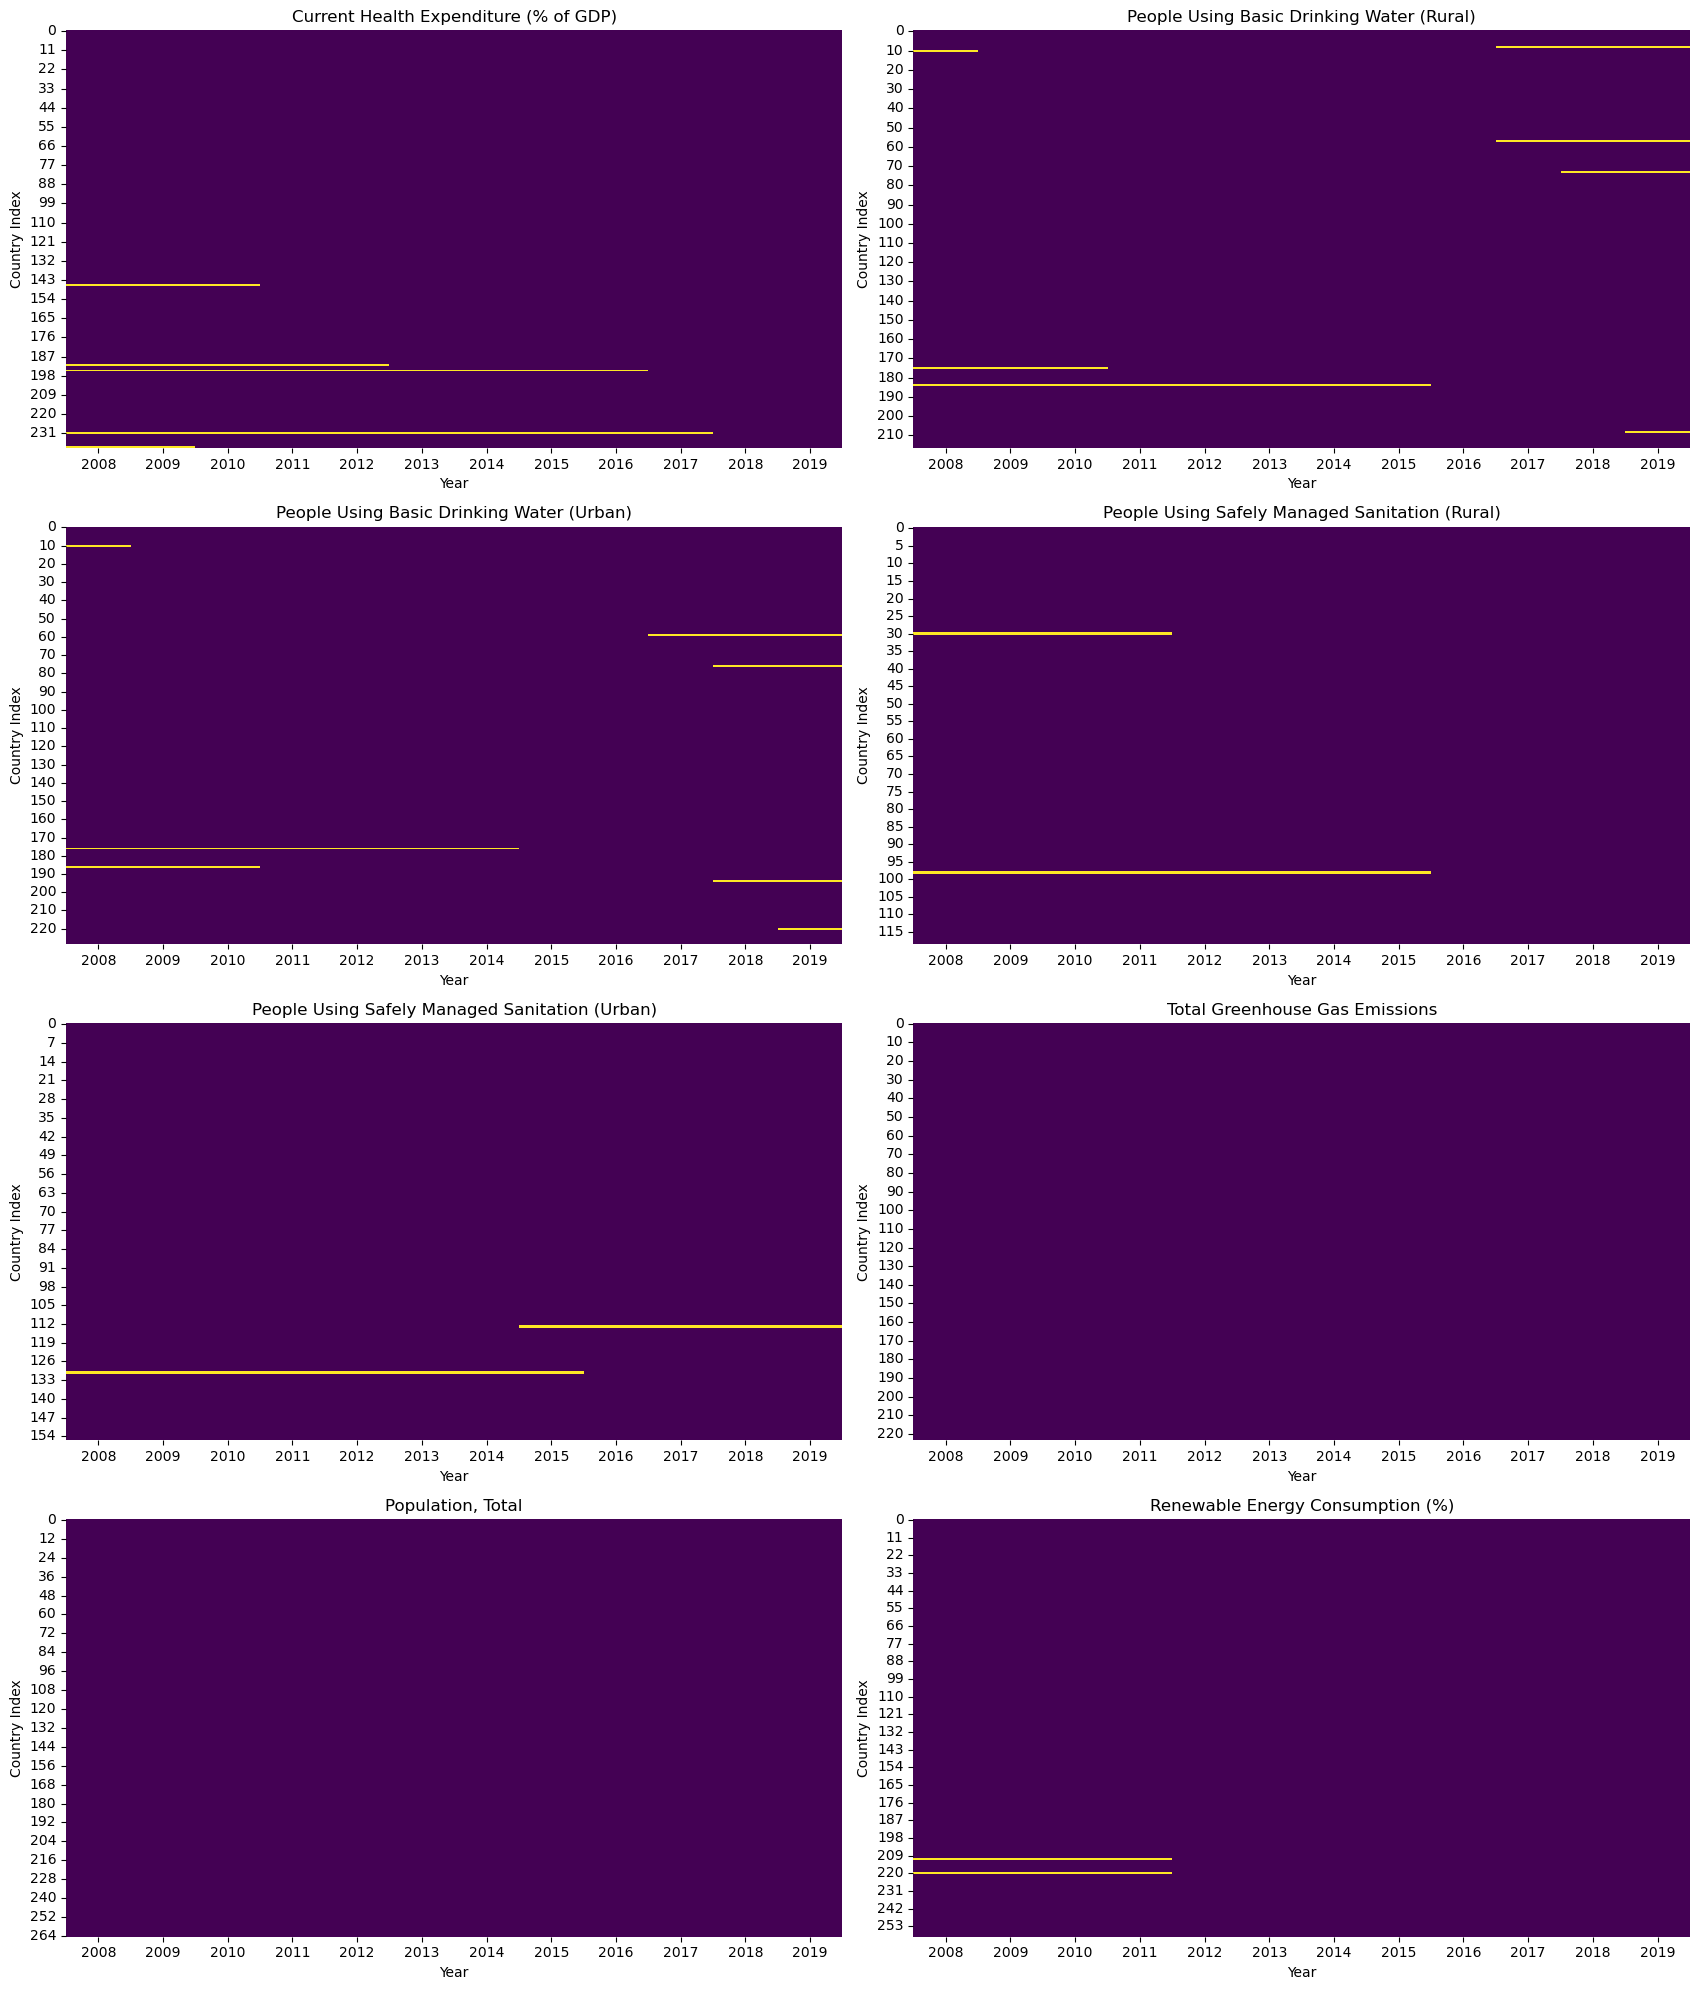

In [30]:
# Tuple of all cleaned DataFrames
all_dfs = (df_che4, df_wr4, df_wu4, df_sr4, df_su4, df_gem4, df_pop4, df_ren4)
titles = [
    "Current Health Expenditure (% of GDP)",
    "People Using Basic Drinking Water (Rural)",
    "People Using Basic Drinking Water (Urban)",
    "People Using Safely Managed Sanitation (Rural)",
    "People Using Safely Managed Sanitation (Urban)",
    "Total Greenhouse Gas Emissions",
    "Population, Total",
    "Renewable Energy Consumption (%)"
]

# Create figure and subplots
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()  # Flatten 4x2 grid to 1D for easy iteration

for i, df in enumerate(all_dfs):
    year_cols = df.columns[4:]  # years start from 5th column
    sns.heatmap(
        df[year_cols].isna(),
        cmap="viridis",
        cbar=False,  # Remove the continuous colorbar, it doesn't make any sense
        ax=axes[i]
    )
    axes[i].set_title(titles[i], fontsize=12)
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel("Country Index")

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust layout to fit legend
plt.show()

The heatmaps above are very helpful, as they clearly show the remaining missing values without causing confusion. It can be seen that pop and gem have no remaining NaNs. Additionally, the other six datasets each have a few countries with some missing values.

#### 3.5.2.1. Current Health Expenditure (% of GDP)

In [31]:
# Display the remaining countries with NaNs (che)
df_che4[df_che4[year_cols].isna().sum(axis=1) > 0]

Country Name Country Code                         Indicator Name  \
146         Montenegro          MNE  Current health expenditure (% of GDP)   
192  Somalia Fed. Rep.          SOM  Current health expenditure (% of GDP)   
195        South Sudan          SSD  Current health expenditure (% of GDP)   
231       Venezuela RB          VEN  Current health expenditure (% of GDP)   
239           Zimbabwe          ZWE  Current health expenditure (% of GDP)   

        Indicator Code  2008  2009       2010      2011      2012      2013  \
146  SH.XPD.CHEX.GD.ZS   NaN   NaN        NaN  7.966922  8.295505  8.471446   
192  SH.XPD.CHEX.GD.ZS   NaN   NaN        NaN       NaN       NaN  2.818393   
195  SH.XPD.CHEX.GD.ZS   NaN   NaN        NaN       NaN       NaN       NaN   
231  SH.XPD.CHEX.GD.ZS   NaN   NaN        NaN       NaN       NaN       NaN   
239  SH.XPD.CHEX.GD.ZS   NaN   NaN  10.475839  8.082884  6.917949  7.109403   

         2014      2015      2016       2017       2018      2019  
146  8.000868  9.021888  8.633030   7.982554   8.343555  8.329832  
192  2.715613  2.842920  2.275338   2.433610   2.371698  2.190595  
195       NaN       NaN       NaN  15.957304  10.056500  9.037411  
231       NaN       NaN       NaN        NaN   2.416913  2.185637  
239  8.132273  7.449827  7.466447   6.172785   4.655271  3.232678

In [32]:
print("Remaining Countries for Current Health Expenditure (% of GDP):", df_che4.shape[0])

Remaining Countries for Current Health Expenditure (% of GDP): 240


All countries with partial missing values in this dataset have their NaNs at the beginning of the time series, which makes interpolation impossible. We decided to drop these countries, as they represent only 2.08% of the dataset and their removal does not affect the overall analysis.

In [33]:
# Drop all rows with any NaN
df_che5 = df_che4.dropna().reset_index(drop=True)

In [34]:
print("Final Countries for Current Health Expenditure (% of GDP):", df_che5.shape[0])

Final Countries for Current Health Expenditure (% of GDP): 235


#### 3.5.2.2. People Using Basic Drinking Water (Rural)

In [35]:
# Display the remaining countries with NaNs (wr)
df_wr4[df_wr4[year_cols].isna().sum(axis=1) > 0]

Country Name Country Code  \
8                         Argentina          ARG   
10              Antigua and Barbuda          ATG   
57                          Eritrea          ERI   
73                Equatorial Guinea          GNQ   
175                     South Sudan          SSD   
184        Turks and Caicos Islands          TCA   
208  St. Vincent and the Grenadines          VCT   

                                                                        Indicator Name  \
8    People using at least basic drinking water services rural (% of rural population)   
10   People using at least basic drinking water services rural (% of rural population)   
57   People using at least basic drinking water services rural (% of rural population)   
73   People using at least basic drinking water services rural (% of rural population)   
175  People using at least basic drinking water services rural (% of rural population)   
184  People using at least basic drinking water services rural (% of rural population)   
208  People using at least basic drinking water services rural (% of rural population)   

        Indicator Code       2008       2009       2010       2011       2012  \
8    SH.H2O.BASW.RU.ZS  87.457334  88.838915  90.220497  91.602079  92.983660   
10   SH.H2O.BASW.RU.ZS        NaN  98.348956  98.348956  98.348956  98.348956   
57   SH.H2O.BASW.RU.ZS  28.864734  28.598945  28.333155  28.067366  27.801576   
73   SH.H2O.BASW.RU.ZS  33.819124  33.210373  32.601622  31.992871  31.384120   
175  SH.H2O.BASW.RU.ZS        NaN        NaN        NaN  38.766466  38.359057   
184  SH.H2O.BASW.RU.ZS        NaN        NaN        NaN        NaN        NaN   
208  SH.H2O.BASW.RU.ZS  96.289486  96.406266  96.523046  96.639826  96.756606   

          2013       2014       2015       2016       2017       2018  \
8    92.983660  92.983660  92.983660  92.983660        NaN        NaN   
10   98.348956  98.348956  98.348956  98.348956  98.348956  98.348956   
57   27.801576  27.801576  27.801576  27.801576        NaN        NaN   
73   30.775369  30.775369  30.775369  30.775369  30.775369        NaN   
175  37.883306  37.339214  36.726780  36.046004  35.296887  34.479429   
184        NaN        NaN        NaN  91.788106  91.788106  91.788106   
208  96.873386  96.990166  96.990166  96.990166  96.990166  96.990166   

          2019  
8          NaN  
10   98.348956  
57         NaN  
73         NaN  
175  33.593629  
184  91.788106  
208        NaN

In [36]:
print("Remaining Countries for People Using Basic Drinking Water (Rural):", df_wr4.shape[0])

Remaining Countries for People Using Basic Drinking Water (Rural): 217


We apply the same approach here as well, dropping all countries with missing values at the beginning of the time series. These countries account for only 1.38% of the dataset.

In [37]:
# Drop all countries with NaNs at the beginning
df_wr5 = df_wr4[~df_wr4['2008'].isna()].reset_index(drop=True)

For Argentina, Eritrea, Equatorial Guinea, and St. Vincent and the Grenadines in the “People Using Basic Drinking Water (Rural)” dataset, the missing values occur at the end of the time series (2017–2019). The preceding years show a stable trend. In this context, forward filling (ffill) is a reasonable approach, as it assumes that the percentage remains consistent in the missing years, which aligns with the gradual or stable behavior of this indicator and avoids introducing unrealistic fluctuations.

In [38]:
# Forward fill missing values for the year columns
year_cols = [str(y) for y in range(2008, 2020)]
df_wr5.loc[df_wr5['Country Name'] == 'Argentina', year_cols] = df_wr5.loc[df_wr5['Country Name'] == 'Argentina', year_cols].ffill(axis=1)
df_wr5.loc[df_wr5['Country Name'] == 'Eritrea', year_cols] = df_wr5.loc[df_wr5['Country Name'] == 'Eritrea', year_cols].ffill(axis=1)
df_wr5.loc[df_wr5['Country Name'] == 'Equatorial Guinea', year_cols] = df_wr5.loc[df_wr5['Country Name'] == 'Equatorial Guinea', year_cols].ffill(axis=1)
df_wr5.loc[df_wr5['Country Name'] == 'St. Vincent and the Grenadines', year_cols] = df_wr5.loc[df_wr5['Country Name'] == 'St. Vincent and the Grenadines', year_cols].ffill(axis=1)

In [39]:
print("Final Countries for People Using Basic Drinking Water (Rural):", df_wr5.shape[0])

Final Countries for People Using Basic Drinking Water (Rural): 214


#### 3.5.2.3. People Using Basic Drinking Water (Urban)

In [40]:
# Display the remaining countries with NaNs (wu)
df_wu4[df_wu4[year_cols].isna().sum(axis=1) > 0]

Country Name Country Code  \
10              Antigua and Barbuda          ATG   
59                          Eritrea          ERI   
76                Equatorial Guinea          GNQ   
176                    Saudi Arabia          SAU   
186                     South Sudan          SSD   
194       Sint Maarten (Dutch part)          SXM   
220  St. Vincent and the Grenadines          VCT   

                                                                        Indicator Name  \
10   People using at least basic drinking water services urban (% of urban population)   
59   People using at least basic drinking water services urban (% of urban population)   
76   People using at least basic drinking water services urban (% of urban population)   
176  People using at least basic drinking water services urban (% of urban population)   
186  People using at least basic drinking water services urban (% of urban population)   
194  People using at least basic drinking water services urban (% of urban population)   
220  People using at least basic drinking water services urban (% of urban population)   

        Indicator Code       2008       2009       2010       2011       2012  \
10   SH.H2O.BASW.UR.ZS        NaN  98.414580  98.414580  98.414580  98.414580   
59   SH.H2O.BASW.UR.ZS  89.994055  89.930097  89.866140  89.802182  89.738225   
76   SH.H2O.BASW.UR.ZS  72.650381  73.735906  74.821431  75.906956  76.992481   
176  SH.H2O.BASW.UR.ZS        NaN        NaN        NaN        NaN        NaN   
186  SH.H2O.BASW.UR.ZS        NaN        NaN        NaN  52.058144  54.158256   
194  SH.H2O.BASW.UR.ZS  95.783231  95.688821  95.594410  95.500000  95.405590   
220  SH.H2O.BASW.UR.ZS  97.186357  97.389345  97.592333  97.795321  97.998309   

          2013       2014       2015       2016       2017       2018  \
10   98.414580  98.414580  98.414580  98.414580  98.414580  98.414580   
59   89.738225  89.738225  89.738225  89.738225        NaN        NaN   
76   78.078006  78.078006  78.078006  78.078006  78.078006        NaN   
176        NaN        NaN  98.406400  98.406400  98.406400  98.406400   
186  56.299749  58.482623  60.706877  62.972513  65.279529  67.627926   
194  95.311179  95.311179  95.311179  95.311179  95.311179        NaN   
220  98.201297  98.404285  98.404285  98.404285  98.404285  98.404285   

          2019  
10   98.414580  
59         NaN  
76         NaN  
176  98.406400  
186  70.017704  
194        NaN  
220        NaN

In [41]:
print("Remaining Countries for People Using Basic Drinking Water (Urban):", df_wu4.shape[0])

Remaining Countries for People Using Basic Drinking Water (Urban): 229


We apply the same here as the countries with NaNs at the beggining represent the 1.31% of the dataset.

In [42]:
# Drop all countries with NaNs at the beginning
df_wu5 = df_wu4[~df_wu4['2008'].isna()].reset_index(drop=True)

In [43]:
# Forward fill missing values for the year columns
year_cols = [str(y) for y in range(2008, 2020)]
df_wu5.loc[df_wu5['Country Name'] == 'Sint Maarten (Dutch part)', year_cols] = df_wu5.loc[df_wu5['Country Name'] == 'Sint Maarten (Dutch part)', year_cols].ffill(axis=1)
df_wu5.loc[df_wu5['Country Name'] == 'Eritrea', year_cols] = df_wu5.loc[df_wu5['Country Name'] == 'Eritrea', year_cols].ffill(axis=1)
df_wu5.loc[df_wu5['Country Name'] == 'Equatorial Guinea', year_cols] = df_wu5.loc[df_wu5['Country Name'] == 'Equatorial Guinea', year_cols].ffill(axis=1)
df_wu5.loc[df_wu5['Country Name'] == 'St. Vincent and the Grenadines', year_cols] = df_wu5.loc[df_wu5['Country Name'] == 'St. Vincent and the Grenadines', year_cols].ffill(axis=1)

In [44]:
print("Final Countries for People Using Basic Drinking Water (Urban):", df_wu5.shape[0])

Final Countries for People Using Basic Drinking Water (Urban): 226


#### 3.5.2.4. People Using Safely Managed Sanitation (Rural)

In [45]:
# Display the remaining countries with NaNs (sr)
df_sr4[df_sr4[year_cols].isna().sum(axis=1) > 0]

Country Name Country Code  \
30  Fragile and conflict affected situations          FCS   
98                  Turks and Caicos Islands          TCA   

                                                                   Indicator Name  \
30  People using safely managed sanitation services rural (% of rural population)   
98  People using safely managed sanitation services rural (% of rural population)   

       Indicator Code  2008  2009  2010  2011       2012       2013  \
30  SH.STA.SMSS.RU.ZS   NaN   NaN   NaN   NaN  19.361526  19.462454   
98  SH.STA.SMSS.RU.ZS   NaN   NaN   NaN   NaN        NaN        NaN   

         2014       2015       2016       2017       2018       2019  
30  19.562954  19.662145  19.757890  19.853066  19.952962  20.056218  
98        NaN        NaN  43.871423  43.871423  43.871423  43.871423

In [46]:
print("Remaining Countries for People Using Safely Managed Sanitation (Rural):", df_sr4.shape[0])

Remaining Countries for People Using Safely Managed Sanitation (Rural): 119


The countries with NaNs at the beginning represent only the 1.68% of the dataset.

In [47]:
df_sr5 = df_sr4[~df_sr4['2008'].isna()].reset_index(drop=True)

In [48]:
print("Final Countries for People Using Safely Managed Sanitation (Rural):", df_sr5.shape[0])

Final Countries for People Using Safely Managed Sanitation (Rural): 117


#### 3.5.2.5. People Using Safely Managed Sanitation (Urban)

In [49]:
# Display the remaining countries with NaNs (su)
df_su4[df_su4[year_cols].isna().sum(axis=1) > 0]

Country Name Country Code  \
113  Pacific island small states          PSS   
130     Turks and Caicos Islands          TCA   

                                                                    Indicator Name  \
113  People using safely managed sanitation services urban (% of urban population)   
130  People using safely managed sanitation services urban (% of urban population)   

        Indicator Code       2008       2009       2010       2011       2012  \
113  SH.STA.SMSS.UR.ZS  40.336632  40.299413  40.254215  40.156591  40.041558   
130  SH.STA.SMSS.UR.ZS        NaN        NaN        NaN        NaN        NaN   

          2013       2014  2015       2016       2017       2018       2019  
113  39.926763  39.811087   NaN        NaN        NaN        NaN        NaN  
130        NaN        NaN   NaN  33.324491  33.324491  33.324491  33.324491

In [50]:
print("Remaining Countries for People Using Safely Managed Sanitation (Urban):", df_su4.shape[0])

Remaining Countries for People Using Safely Managed Sanitation (Urban): 156


We will drop both entries here, even though the Pacific island small states region has missing values only at the end of the time series. Because this row represents an aggregated region rather than a sovereign single country and many of its member island states lack consistent reporting, meaningful comparisons cannot be performed.

In [51]:
# Drop both
df_su5 = df_su4[~df_su4['2008'].isna()].reset_index(drop=True)
df_su5 = df_su5[~df_su5['2019'].isna()].reset_index(drop=True)

In [52]:
print("Final Countries for People Using Safely Managed Sanitation (Urban):", df_su5.shape[0])

Final Countries for People Using Safely Managed Sanitation (Urban): 154


#### 3.5.2.6. Renewable Energy Consumption (%)

In [53]:
# Display the remaining countries with NaNs (su)
df_ren4[df_ren4[year_cols].isna().sum(axis=1) > 0]

Country Name Country Code  \
211                South Sudan          SSD   
220  Sint Maarten (Dutch part)          SXM   

                                                         Indicator Name  \
211  Renewable energy consumption (% of total final energy consumption)   
220  Renewable energy consumption (% of total final energy consumption)   

     Indicator Code  2008  2009  2010  2011  2012  2013  2014  2015  2016  \
211  EG.FEC.RNEW.ZS   NaN   NaN   NaN   NaN  30.6  30.1  29.4  27.5  28.7   
220  EG.FEC.RNEW.ZS   NaN   NaN   NaN   NaN   0.0   0.0   0.0   0.0   0.0   

     2017  2018  2019  
211  35.1  31.5  31.4  
220   0.0   0.0   0.0

In [54]:
print("Remaining Countries for Renewable Energy Consumption (%):", df_ren4.shape[0])

Remaining Countries for Renewable Energy Consumption (%): 260


We will drop them both as they contain NaNs at the beginning and they represent only the 0.76% of the dataset.

In [55]:
# Drop them
df_ren5 = df_ren4[~df_ren4['2008'].isna()].reset_index(drop=True)

In [56]:
print("Final Countries for Renewable Energy Consumption (%):", df_ren5.shape[0])

Final Countries for Renewable Energy Consumption (%): 258


#### 3.5.2.7. Rationale for Handling Countries with Partial Missing Values

Since we justified keeping our originally selected indicators regardless of how many all-NaN countries they contained, we also need to explain how we handled the remaining partial missing values. Fortunately, the number of partial-NaN cases is very small compared to the total number of countries in each dataset and two datasets contain no remaining missing values at all.

For the datasets with partial missing values, we applied a consistent rule:

1) Countries with missing values at the beginning of the time series were dropped, because no historical trend exists to support any reliable imputation.

2) Countries with missing values only at the end of the time series were forward-filled, since the earlier values show stable or slowly changing trends that justify extending the last known value.

## 3.6. Country Standardization Checks

It is unlikely that our datasets require country-name standardization, since all of them come directly from the World Bank and follow the same naming conventions. However, in this section, we verify this assumption to ensure full consistency across the datasets.

In [57]:
# Run the country comparison and print the result
same_cntr_list, same_cntr_codes = custom_functions.check_same_countries(
    df_che=df_che, df_wr=df_wr, df_wu=df_wu, df_sr=df_sr,
    df_su=df_su, df_gem=df_gem, df_pop=df_pop, df_ren=df_ren
)

print("If this prints '266', countries don't need standardization:", len(same_cntr_list))
print("If this prints '266', country codes don't need standardization:", len(same_cntr_codes))

If this prints '266', countries don't need standardization: 266
If this prints '266', country codes don't need standardization: 266


The result is as expected, and the countries are consistent across all eight datasets. We can safely proceed with the comparisons between them.

## 3.7. Confirm that Column Names are the Same

With a quick look, all columns across the datasets seem to be the same. However, we will confirm this in this section.

In [58]:
# Final DataFrames list
dfs = [df_che5, df_wr5, df_wu5, df_sr5, df_su5, df_gem4, df_pop4, df_ren5]

for df in dfs:
    if df.columns.tolist() == dfs[0].columns.tolist():  # Take dfs[0  (che) as a reference and compare it with all other dfs
        print("Columns are the same!")
    else:
        print("Columns differ!")

Columns are the same!
Columns are the same!
Columns are the same!
Columns are the same!
Columns are the same!
Columns are the same!
Columns are the same!
Columns are the same!


The result is as expected. Ultimately, neither the country names nor the country codes require standardization and the columns do not need to be renamed to match each other.

## 3.8. Check for Duplicate Country Codes

It's also important to check for duplicates in coyntry codes because this will be our primary key for "countries" table.

In [59]:
for i, df in enumerate(dfs, 1):
    duplicates = df['Country Code'].duplicated().sum()
    print(f"DataFrame {i}: {duplicates} duplicate rows in 'Country Code'")

DataFrame 1: 0 duplicate rows in 'Country Code'
DataFrame 2: 0 duplicate rows in 'Country Code'
DataFrame 3: 0 duplicate rows in 'Country Code'
DataFrame 4: 0 duplicate rows in 'Country Code'
DataFrame 5: 0 duplicate rows in 'Country Code'
DataFrame 6: 0 duplicate rows in 'Country Code'
DataFrame 7: 0 duplicate rows in 'Country Code'
DataFrame 8: 0 duplicate rows in 'Country Code'


The result above is encouraging, as it shows that all country codes are unique in each dataset.

# 4. Database Creation

We could use an .env file to store our password for better security and a more professional setup. However, we will keep a simpler approach for now because we are working under time pressure.

## 4.1. Connect to MySQL Local Server

In [60]:
my_host = 'localhost'  # Change it if needed
my_user = 'root'  # Change it if needed
my_password = 'XXX'
# Establish a connection using pymysql library
connection = pymysql.connect(host=my_host, user=my_user, password=my_password, autocommit=True)

# Create a cursor that works through this specific connection
cursor = connection.cursor()

## 4.2. Create the Database

In [61]:
# Create the database
# The cursor is still open and connected
cursor.execute("DROP DATABASE IF EXISTS WorldBank;")
cursor.execute("CREATE DATABASE WorldBank;")
cursor.execute("USE WorldBank;")

0

## 4.3. Fix the Data to Meet the Recommended Data Model

### 4.3.1. Table "countries"

We have a separate CSV file in this table format, containing country ID, country name, and region, requiring minimal cleaning. Let’s read it into a DataFrame.

In [62]:
countries = pd.read_csv('original_data_and_region_mapping/region_list.csv')

In [63]:
# Drop country_id columns
countries = countries.drop(columns='country_id')

# Create the real country_id column
countries = countries.rename(columns={'country_code': 'country_id'})

# Set it as the index
countries = countries.set_index('country_id')

In [64]:
# We are satisfied with our result.
countries.head(2)

country_name                   region
country_id                                      
AGO              Angola                   Africa
ALB             Albania  Europe and Central Asia

The DataFrame above is fully prepared to populate the countries table of our database.

### 4.3.2. Table "indicators"

Now, we create the DataFrame which will populate the indicators table of our data model.

In [65]:
# Extract the indicator info from each dataset
indicator_list = []
for df in dfs:
    indicator = df[['Indicator Code', 'Indicator Name']].iloc[0]  # first row only since each dataset contain the same indicator
    indicator_list.append(indicator)

# Concatenate into a single DataFrame
indicators = pd.DataFrame(indicator_list)

# Rename columns to match data model
indicators = indicators.rename(columns={
    'Indicator Code': 'indicator_id',
    'Indicator Name': 'indicator_name'
})

# Use the abbreviations to make things much simpler
# Mapping dictionary
abbr_map = {
    'SH.XPD.CHEX.GD.ZS': 'CHE',
    'SH.H2O.BASW.RU.ZS': 'WR',
    'SH.H2O.BASW.UR.ZS': 'WU',
    'SH.STA.SMSS.RU.ZS': 'SR',
    'SH.STA.SMSS.UR.ZS': 'SU',
    'EN.GHG.ALL.LU.MT.CE.AR5': 'GEM',
    'SP.POP.TOTL': 'POP',
    'EG.FEC.RNEW.ZS': 'REN'
}

# Apply the mapping
indicators['indicator_id'] = indicators['indicator_id'].map(abbr_map)

# make indicator_id the DataFrame's index
indicators = indicators.set_index('indicator_id')

In [66]:
# Create the unit column
indicators['unit'] = '% of GDP'  # che
indicators.at[indicators.index[1], 'unit'] = '% of Rural Population'  # wr
indicators.at[indicators.index[2], 'unit'] = '% of Urban Population'  # wu
indicators.at[indicators.index[3], 'unit'] = '% of Rural Population'  # sr
indicators.at[indicators.index[4], 'unit'] = '% of Urban Population'  # su
indicators.at[indicators.index[5], 'unit'] = 'Million Tonnes of CO2'  # gem
indicators.at[indicators.index[6], 'unit'] = 'Humans'  # pop
indicators.at[indicators.index[7], 'unit'] = '% of Total Final Energy Consumption'  # ren

# Remove the unit from indicator_name
indicators['indicator_name'] = indicators['indicator_name'].apply(lambda x: re.sub(r'\s*\(.*\)$', '', x))

indicators

indicator_name  \
indicator_id                                                              
CHE                                          Current health expenditure   
WR            People using at least basic drinking water services rural   
WU            People using at least basic drinking water services urban   
SR                People using safely managed sanitation services rural   
SU                People using safely managed sanitation services urban   
GEM                     Total greenhouse gas emissions including LULUCF   
POP                                                    Population total   
REN                                        Renewable energy consumption   

                                             unit  
indicator_id                                       
CHE                                      % of GDP  
WR                          % of Rural Population  
WU                          % of Urban Population  
SR                          % of Rural Population  
SU                          % of Urban Population  
GEM                         Million Tonnes of CO2  
POP                                        Humans  
REN           % of Total Final Energy Consumption

We are very satisfied with our final result, as the indicators DataFrame is fully ready to populate the indicators table.

### 4.3.3. Table "values"

In [67]:
# List to collect all long-format data
values_list = []

for df in dfs:
    # Determine the indicator abbreviation
    ind_code = df['Indicator Code'].iloc[0]
    ind_abbr = abbr_map[ind_code]
    
    # Convert the format
    year_cols = [str(y) for y in range(2008, 2020)]  # Store years as strings
    
    df_coverted = df.melt(
        id_vars=['Country Name', 'Country Code'],  # columns to keep as identifiers
        value_vars=year_cols,  # columns to be converted to another format
        var_name='year',  # new col name for columns
        value_name='value'  # new col name for values
    )
    
    # Add indicator_id column
    df_coverted['indicator_id'] = ind_abbr
    
    # Rename country_code to country_id to match the schema
    df_coverted = df_coverted.rename(columns={'Country Code': 'country_id'})
    
    # Select only the columns needed for values_table
    df_coverted = df_coverted[['country_id', 'indicator_id', 'year', 'value']]
    
    # Append to list
    values_list.append(df_coverted)

# Concatenate all indicators into one DataFrame
values = pd.concat(values_list, ignore_index=True)

# Optional: convert year and value to proper types
values['year'] = values['year'].astype(int)
values['value'] = pd.to_numeric(values['value'], errors='coerce')

values.head()

country_id indicator_id  year      value
0        AFE          CHE  2008   5.886538
1        AFG          CHE  2008  10.256495
2        AFW          CHE  2008   3.654871
3        AGO          CHE  2008   3.322903
4        ALB          CHE  2008   5.509003

The result is awesome. We can continue our work trying to populate the database.

## 4.4. Create the Tables MySQL Schema

In [68]:
# Countries table
cursor.execute("DROP TABLE IF EXISTS countries;")
cursor.execute("""
CREATE TABLE countries (
    country_id VARCHAR(3) PRIMARY KEY,
    country_name VARCHAR(255),
    region VARCHAR(255)
);
""")

# Indicators table
cursor.execute("DROP TABLE IF EXISTS indicators;")
cursor.execute("""
CREATE TABLE indicators (
    indicator_id VARCHAR(3) PRIMARY KEY,
    indicator_name VARCHAR(255),
    unit VARCHAR(50)
);
""")

# Values table
cursor.execute("DROP TABLE IF EXISTS values_table;")
cursor.execute("""
CREATE TABLE values_table (
    country_id VARCHAR(3),
    indicator_id VARCHAR(3),
    year INT,
    value DOUBLE,
    PRIMARY KEY (country_id, indicator_id, year),
    FOREIGN KEY (country_id) REFERENCES countries(country_id),
    FOREIGN KEY (indicator_id) REFERENCES indicators(indicator_id)
);
""")

0

## 4.5. Populate the Tables

In [69]:
# Disable foreign key checks to safely delete
# We can't delete any rows otherwise
cursor.execute("SET FOREIGN_KEY_CHECKS = 0;")

# Populate countries table
cursor.execute("DELETE FROM countries;")  # Remove all rows, keeping schema intact
countries_rows = countries.reset_index().values.tolist()
cursor.executemany(
    "INSERT INTO countries (country_id, country_name, region) VALUES (%s, %s, %s)",
    countries_rows)

# Populate indicators table
cursor.execute("DELETE FROM indicators;")
indicators_rows = indicators.reset_index().values.tolist()
cursor.executemany(
    "INSERT INTO indicators (indicator_id, indicator_name, unit) VALUES (%s, %s, %s)",
    indicators_rows)

# Populate values table
cursor.execute("DELETE FROM values_table;")
values_rows = values.values.tolist()
cursor.executemany(
    "INSERT INTO values_table (country_id, indicator_id, year, value) VALUES (%s, %s, %s, %s)",
    values_rows)

20316

## 4.6. How Stakeholders would Access and Export the Updated and Cleaned Tables

We want to simulate real-life activities. We assume that the cleaned data have been uploaded to our company's database and can be accessed by our stakeholders. Let’s simulate a direct download from the updated database. We can bring the data into Python using read_sql() and of course, we can also save it to CSV files.

**Here is a self-contained script cell that reads the updated and cleaned tables into DataFrames and also exports them to CSV files:**

In [70]:
import pymysql
import pandas as pd

# Establish connection
connection = pymysql.connect(
    host='localhost',  # change if needed
    user='root',  # your MySQL username
    password='XXX',  # your MySQL password
    database='worldbank',  # your database name
    autocommit=True
)

cursor = connection.cursor()

# Countries table
cursor.execute("SELECT * FROM countries;")
countries_data = cursor.fetchall()
countries_columns = [desc[0] for desc in cursor.description]
countries_df = pd.DataFrame(countries_data, columns=countries_columns)

# Indicators table
cursor.execute("SELECT * FROM indicators;")
indicators_data = cursor.fetchall()
indicators_columns = [desc[0] for desc in cursor.description]
indicators_df = pd.DataFrame(indicators_data, columns=indicators_columns)

# Values table 
cursor.execute("SELECT * FROM values_table;")  # backticks for reserved keyword
values_data = cursor.fetchall()
values_columns = [desc[0] for desc in cursor.description]
values_df = pd.DataFrame(values_data, columns=values_columns)

# Also save to CSV
# countries_df.to_csv("countries.csv", index=False)
# indicators_df.to_csv("indicators.csv", index=False)
# values_df.to_csv("values.csv", index=False)

# Close connection
# cursor.close()
# connection.close()

## 4.7. MySQL Queries Using pymysql

### 4.7.1. Yearly Averages and Standard Deviations for each Indicator per Region

In [71]:
# SQL query: yearly averages and standard deviations per indicator per region
sql_1 = """
SELECT c.region, v.indicator_id, v.year, AVG(v.value) AS avg_value, STD(v.value) AS std_value
FROM values_table v
JOIN countries c ON v.country_id = c.country_id
GROUP BY c.region, v.indicator_id, v.year
ORDER BY c.region, v.indicator_id, v.year;
"""

# Execute query
cursor.execute(sql_1)

# Fetch results
data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

# Load into DataFrame
sql_1_df = pd.DataFrame(data, columns=columns)

### 4.7.2. 10 year Rolling Average for One Country for All Indicators

In [72]:
# Fetch values for the US
country_id = 'USA'
sql_1 = f"""
SELECT indicator_id, year, value
FROM values_table
WHERE country_id = '{country_id}'
ORDER BY indicator_id, year;
"""
cursor.execute(sql_1)
data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
us_df = pd.DataFrame(data, columns=columns)

# Pivot to have years as rows and indicators as columns
pivot_df = us_df.pivot(index='year', columns='indicator_id', values='value')

# Pivot to have years as rows and indicators as columns
pivot_df = us_df.pivot(index='year', columns='indicator_id', values='value')

# Compute rolling average per indicator using all available years
rolling_df = pivot_df.rolling(window=10, min_periods=1).mean().reset_index()

rolling_df

indicator_id  year        CHE          GEM           POP       REN         SU  \
0             2008  15.207240  5954.607200  3.040940e+08  6.800000  96.846851   
1             2009  15.703959  5750.737650  3.054327e+08  7.050000  96.880748   
2             2010  15.868383  5756.480300  3.067479e+08  7.166667  96.913071   
3             2011  15.936290  5694.295325  3.080208e+08  7.475000  96.945076   
4             2012  15.972981  5610.825640  3.092845e+08  7.680000  96.977014   
5             2013  15.975187  5585.697883  3.105248e+08  7.883333  97.008970   
6             2014  16.006466  5568.878571  3.117723e+08  8.042857  97.040978   
7             2015  16.065858  5551.867662  3.130277e+08  8.150000  97.064522   
8             2016  16.146445  5516.384322  3.142861e+08  8.277778  97.082437   
9             2017  16.207102  5480.734770  3.155183e+08  8.420000  97.096427   
10            2018  16.347908  5421.185270  3.179619e+08  8.730000  97.133646   
11            2019  16.393966  5395.583390  3.203074e+08  9.020000  97.163770   

indicator_id         WR         WU  
0             95.700638  99.699657  
1             95.700638  99.699657  
2             95.811490  99.706250  
3             95.950055  99.714492  
4             96.099706  99.723393  
5             96.254899  99.732624  
6             96.413259  99.742044  
7             96.573598  99.751581  
8             96.735257  99.761196  
9             96.897840  99.770867  
10            97.197141  99.788669  
11            97.529697  99.808450

There is no any data for People Using Safely Managed Sanitation Services, Rural for the USA.


### 4.7.3. Top & Bottom Countries for each Indicator for the last 10 Years

In [73]:
# Fetch values joined with country regions for the last 10 years
sql_3 = """
SELECT v.country_id, c.region, v.indicator_id, v.year, v.value
FROM values_table v
JOIN countries c ON v.country_id = c.country_id
WHERE v.year BETWEEN 2010 AND 2019;
"""
cursor.execute(sql_3)
data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

# Convert to DataFrame
sql_3_df = pd.DataFrame(data, columns=columns)

# Compute 10-year average per country and indicator
avg_df = sql_3_df.groupby(['region', 'indicator_id', 'country_id'])['value'].mean().reset_index()
avg_df = avg_df.rename(columns={'value': 'avg_value'})

# Prepare containers for results
top10_list = []
bottom10_list = []

# Loop per region and indicator to get top/bottom 10
for (region, indicator), group in avg_df.groupby(['region', 'indicator_id']):
    sorted_group = group.sort_values('avg_value', ascending=False)
    top10_list.append(sorted_group.head(10))
    bottom10_list.append(sorted_group.tail(10))

# Combine results
top10_df = pd.concat(top10_list).reset_index(drop=True)
bottom10_df = pd.concat(bottom10_list).reset_index(drop=True)

With the scripts above, we can explore the top 10 or bottom 10 countries in each region for a chosen indicator and display them. For example, the script below shows the top 10 African countries based on current health expenditure.

Here is an example of how powerful is the above query. Here we print top 10 Africa countries in current health expenditure.

In [74]:
top10_df[(top10_df['indicator_id'] == 'CHE') & (top10_df['region'] == 'Africa')]

region indicator_id country_id  avg_value
0  Africa          CHE        SLE  12.238443
1  Africa          CHE        LSO  11.000789
2  Africa          CHE        LBR   9.402281
3  Africa          CHE        NAM   9.101404
4  Africa          CHE        BDI   8.247719
5  Africa          CHE        ZAF   8.015504
6  Africa          CHE        SWZ   7.617446
7  Africa          CHE        GNB   7.234716
8  Africa          CHE        RWA   7.077529
9  Africa          CHE        STP   6.838910